**5420 ANOMALY DETECTION**

**A7:** Unsupervised Machine Learning Techniques Assignment II

Zeying Liu (zl3121)

# 0. Content


>[Content](#scrollTo=vljV_ZdOL2vd)

>[Data Overview & Preparation](#scrollTo=sSZZOSNIS385)

>[Feature Engineering](#scrollTo=rDLpFG2ckfZ2)

>>[2.1 ratio(mean(DRG_State))：Average_Total_Payments](#scrollTo=nW-bW18Ako4T)

>>[2.2 ratio(mean(DRG_State)): Average_Medicare_Payment](#scrollTo=g-_qsmHZ3I0f)

>>[2.3 ratio(mean(DRG_State)): Total_Discharges](#scrollTo=w2lSMEw5TcuK)

>>[2.4 ratio(mean(DRG_region)): Average_Total_Payments](#scrollTo=xUhfUXHwVfOQ)

>>[2.5 ratio(mean(DRG_region)): Average_Medicare_Payment](#scrollTo=E6amsNs1YIrw)

>>[2.6 ratio(mean(DRG_region)): Total_Discharges](#scrollTo=EOdo5ZbeYpw6)

>>[2.7 ratio(mean(DRG_region)): Total_Payments](#scrollTo=4pMLdJbTfbgS)

>>[2.8 ratio(mean(DRG_State)): Total_Payments](#scrollTo=QOX37mBX45A6)

>>[2.9 ratio(mean(DRG)): Total_Discharges](#scrollTo=-4IkNvsw55JH)

>>[2.10 ratio(mean(DRG_State)): Coverage](#scrollTo=EqAjMJgzJj7E)

>>[2.11 ratio(mean(DRG_region)): Medical_Coverage](#scrollTo=y-aV1mXqK0uB)

>[Merge](#scrollTo=RmwPVarUYfnd)

>[Modeling](#scrollTo=I9Xm968EYu-y)

>>[4.1 Select features](#scrollTo=Q8xS-JECoETX)

>>[4.2 Split & Standardize](#scrollTo=ul8Mp_JzoIU_)

>>[4.3 Method: Autoencoder](#scrollTo=Wco3f6prpaoI)

>>>[4.3.1 Build the Model](#scrollTo=5mKdf1X4wBIE)

>>>>[Model 1: [11, 2, 2, 11]](#scrollTo=e_1k58cLwp55)

>>>>[MOdel 2: [11, 5, 2, 5, 11]](#scrollTo=EGyiK4rf3_ie)

>>>>[Model 3: [11, 8, 5, 2, 5, 8, 11]](#scrollTo=h-fgOwVq90_6)

>[Aggregating Models](#scrollTo=UmcqBlimBwIS)

>>[5.1 Average](#scrollTo=4RcvljGNCvKy)

>>[5.2 Maximum of Maximum （MOM）](#scrollTo=vc3ig49gE0KM)

>>[5.3 The Average of Maximum (AOM)](#scrollTo=R0Le8kcCFMhK)

>>[5.4 The maximum of average (MOA)](#scrollTo=q8Rzd6mQGHJ9)

>[Isolated Forest](#scrollTo=vY2Qi41LHh6M)

>>[6.1 Build the Model](#scrollTo=pGketeRSH05a)

>>>[Model 1: max_samples = 163065](#scrollTo=ZhhsYWV1IeFt)



# 1. Data Overview & Preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
data = pd.read_csv('inpatientCharges.csv')

In [ ]:
# Change Columns' name
data.columns = ['DRG','Provider_Id', 'Provider_Name','Provider_StreetAddress','Provider_City',
               'Provider_State','Provider_Zipcode','Hospital_referral_region_desp',
                'Total_Discharges','Average_Covered_Charges','Average_Total_Payments',
                'Average_Medicare_Payment']
data = data.drop('Average_Covered_Charges',axis=1)

In [ ]:
# Check missing data
data.isna().sum()

DRG                              0
Provider_Id                      0
Provider_Name                    0
Provider_StreetAddress           0
Provider_City                    0
Provider_State                   0
Provider_Zipcode                 0
Hospital_referral_region_desp    0
Total_Discharges                 0
Average_Total_Payments           0
Average_Medicare_Payment         0
dtype: int64

In [ ]:
# Change data type and transfer spending amount with dollar sign into numeric
data['DRG'] = data['DRG'].astype('category')
data['Provider_State'] = data['Provider_State'].astype('category')
data['Provider_City'] = data['Provider_City'].astype('category')
data['Provider_Id'] = data['Provider_Id'].astype('category')
data['Average_Total_Payments'] = (data['Average_Total_Payments']
                              .str.replace(r'[^-+\d.]', '').astype(float))
data['Average_Medicare_Payment'] = (data['Average_Medicare_Payment']
                              .str.replace(r'[^-+\d.]', '').astype(float))
data.info()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 11 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   DRG                            163065 non-null  category
 1   Provider_Id                    163065 non-null  category
 2   Provider_Name                  163065 non-null  object  
 3   Provider_StreetAddress         163065 non-null  object  
 4   Provider_City                  163065 non-null  category
 5   Provider_State                 163065 non-null  category
 6   Provider_Zipcode               163065 non-null  int64   
 7   Hospital_referral_region_desp  163065 non-null  object  
 8   Total_Discharges               163065 non-null  int64   
 9   Average_Total_Payments         163065 non-null  float64 
 10  Average_Medicare_Payment       163065 non-null  float64 
dtypes: category(4), float64(2), int64(2), object(3)
memory usage: 9.9+ MB


In [ ]:
data.head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,5777.24,4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,5787.57,4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,5434.95,4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,5417.56,4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,5658.33,4851.44


# 2. Feature Engineering

## 2.1 ratio(mean(DRG_State))：Average_Total_Payments

Text(0.5, 1.0, 'Avg. Total Payments for DRG = 039')

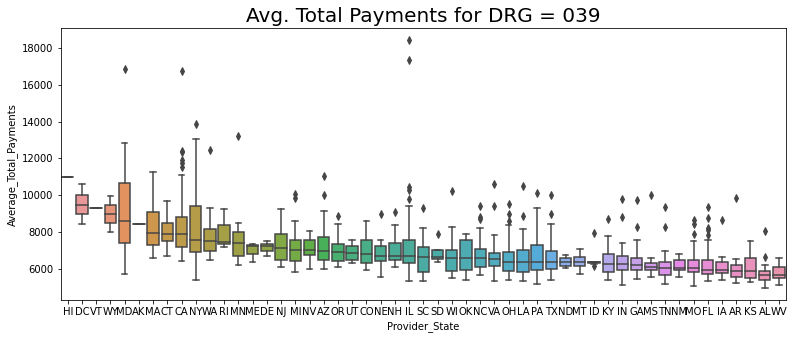

In [ ]:
# Visualize data with DRG 039(order by median)
data_039 = data[data["DRG"] == "039 - EXTRACRANIAL PROCEDURES W/O CC/MCC"]
sorted_index = data_039[['Provider_State', 'Average_Total_Payments']].groupby(by='Provider_State').median().sort_values(by='Average_Total_Payments',ascending=False).index
plt.figure(figsize=(13,5))
sns.boxplot(x="Provider_State", y="Average_Total_Payments",
            order = sorted_index, data=data_039)
plt.title('Avg. Total Payments for DRG = 039',fontsize=20)

**`Findings:`**

Hawaii has the highest cost of treatment of *039 - EXTRACRANIAL PROCEDURES W/O CC/MCC* than other states. West Virginia has the lowest. There are huge variation of the price in Maryland and New York.

It is clear that the average total payment for the same treatment **varies from state to state**. Therefore, further discussion of location and treatment is necessary when comparing costs.

In [ ]:
benchmark = data.groupby(['Provider_State','DRG'])['Average_Total_Payments'].mean().reset_index()
benchmark.columns = ['Provider_State','DRG','Avg_Payment_ByStateDRG']
benchmark.head()

,Provider_State,DRG,Avg_Payment_ByStateDRG
0,AK,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,8401.950000
1,AK,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,8799.000000
2,AK,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,21608.010000
3,AK,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,12555.548333
4,AK,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,9275.867500


In [ ]:
# add to the dataset 
df1 = pd.merge(data, benchmark, how='left', on=['Provider_State', 'DRG'])
# Feature 1:
df1['DRG_state_avg_ratio_amount'] = np.where(df1['Avg_Payment_ByStateDRG']==0,0, df1['Average_Total_Payments'] / df1['Avg_Payment_ByStateDRG'])
df1['DRG_state_avg_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.195274
min           0.384805
25%           0.880824
50%           0.956830
75%           1.064688
max           7.857934
Name: DRG_state_avg_ratio_amount, dtype: float64

[Text(0, 0, '(0.384, 0.694]'),
 Text(0, 0, '(0.694, 0.822]'),
 Text(0, 0, '(0.822, 0.864]'),
 Text(0, 0, '(0.864, 0.957]'),
 Text(0, 0, '(0.957, 1.102]'),
 Text(0, 0, '(1.102, 1.239]'),
 Text(0, 0, '(1.239, 1.663]'),
 Text(0, 0, '(1.663, 7.858]')]

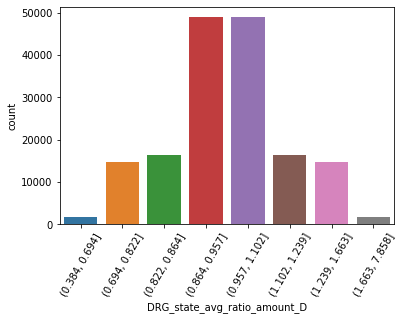

In [ ]:
# cut by percentile for plotting
var = 'DRG_state_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.1,0.2,0.5,0.8,0.9,0.99,1]
df1[binned_var] = pd.qcut(df1[var],percentile)

# Visualization
g = sns.countplot(x="DRG_state_avg_ratio_amount_D", data=df1)
g.set_xticklabels(g.get_xticklabels(), rotation = 60)

Assuming that the top 10% of the DRG_state_avg_ratio_amount might be fraud, choose 1.23 as the threshold to filter out the following records.

In [ ]:
df1[df1['DRG_state_avg_ratio_amount']>1.23].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Avg_Payment_ByStateDRG,DRG_state_avg_ratio_amount,DRG_state_avg_ratio_amount_D
7,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10033,UNIVERSITY OF ALABAMA HOSPITAL,619 SOUTH 19TH STREET,BIRMINGHAM,AL,35233,AL - Birmingham,32,8031.12,5858.50,5743.611739,1.398270,"(1.239, 1.663]"
26,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30007,VERDE VALLEY MEDICAL CENTER,269 SOUTH CANDY LANE,COTTONWOOD,AZ,86326,AZ - Phoenix,18,9133.00,8008.11,7271.555833,1.255990,"(1.239, 1.663]"
31,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30023,FLAGSTAFF MEDICAL CENTER,1200 NORTH BEAVER STREET,FLAGSTAFF,AZ,86001,AZ - Phoenix,15,11026.33,9056.06,7271.555833,1.516365,"(1.239, 1.663]"
36,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30062,SUMMIT HEALTHCARE REGIONAL MEDICAL CENTER,2200 SHOW LOW LAKE ROAD,SHOW LOW,AZ,85901,AZ - Phoenix,17,10000.82,7321.64,7271.555833,1.375334,"(1.239, 1.663]"
59,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,40078,NATIONAL PARK MEDICAL CENTER,1910 MALVERN AVENUE,HOT SPRINGS,AR,71901,AR - Little Rock,18,9838.11,8533.83,6118.828750,1.607842,"(1.239, 1.663]"


## 2.2 ratio(mean(DRG_State)): Average_Medicare_Payment

Text(0.5, 1.0, 'Avg. Total Medicare Payments for DRG = 039')

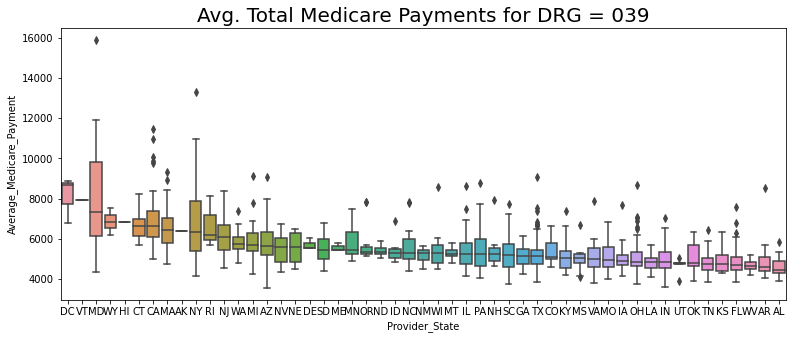

In [ ]:
# Visualize data with DRG 039(order by median)
data_039 = data[data["DRG"] == "039 - EXTRACRANIAL PROCEDURES W/O CC/MCC"]
sorted_index = data_039[['Provider_State', 'Average_Medicare_Payment']].groupby(by='Provider_State').median().sort_values(by='Average_Medicare_Payment',ascending=False).index
plt.figure(figsize=(13,5))
sns.boxplot(x="Provider_State", y="Average_Medicare_Payment",
            order = sorted_index, data=data_039)
plt.title('Avg. Total Medicare Payments for DRG = 039',fontsize=20)

**`Findings:`**

Washington DC has the highest cost of treatment of 0*39 - EXTRACRANIAL PROCEDURES W/O CC/MCC* than other states. Alabama has the lowest. There are still huge variation of the price in Maryland and New York.

In [ ]:
benchmark = data.groupby(['Provider_State','DRG'])['Average_Medicare_Payment'].mean().reset_index()
benchmark.columns = ['Provider_State','DRG','Avg_Medicare_Payment_ByStateDRG']
benchmark.head()

,Provider_State,DRG,Avg_Medicare_Payment_ByStateDRG
0,AK,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,6413.780000
1,AK,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,8081.540000
2,AK,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,20555.255000
3,AK,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,11140.963333
4,AK,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,8258.427500


In [ ]:
# add to the dataset 
df2 = pd.merge(data, benchmark, how='left', on=['Provider_State', 'DRG'])
# Feature 2:
df2['DRG_state_avg_ratio_amount_medicare'] = np.where(df2['Avg_Medicare_Payment_ByStateDRG']==0,0, df2['Average_Medicare_Payment'] / df2['Avg_Medicare_Payment_ByStateDRG'])
df2['DRG_state_avg_ratio_amount_medicare'].describe()

count    163065.000000
mean          1.000000
std           0.215091
min           0.339831
25%           0.868395
50%           0.954250
75%           1.071483
max           5.174415
Name: DRG_state_avg_ratio_amount_medicare, dtype: float64

[Text(0, 0, '(0.339, 0.655]'),
 Text(0, 0, '(0.655, 0.8]'),
 Text(0, 0, '(0.8, 0.849]'),
 Text(0, 0, '(0.849, 0.954]'),
 Text(0, 0, '(0.954, 1.111]'),
 Text(0, 0, '(1.111, 1.268]'),
 Text(0, 0, '(1.268, 1.744]'),
 Text(0, 0, '(1.744, 5.174]')]

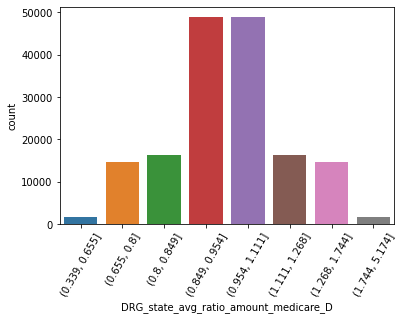

In [ ]:
# cut by percentile for plotting
var = 'DRG_state_avg_ratio_amount_medicare'
binned_var = var + '_D'
percentile = [0,0.01,0.1,0.2,0.5,0.8,0.9,0.99,1]
df2[binned_var] = pd.qcut(df2[var],percentile)

# Visualization
g = sns.countplot(x="DRG_state_avg_ratio_amount_medicare_D", data=df2)
g.set_xticklabels(g.get_xticklabels(), rotation = 60)

Assuming that the top 10% of the DRG_state_avg_ratio_amount_medicare might be fraud, choose 1.25 as the threshold to filter out the following records.

In [ ]:
df2[df2['DRG_state_avg_ratio_amount_medicare']>1.25].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Avg_Medicare_Payment_ByStateDRG,DRG_state_avg_ratio_amount_medicare,DRG_state_avg_ratio_amount_medicare_D
7,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10033,UNIVERSITY OF ALABAMA HOSPITAL,619 SOUTH 19TH STREET,BIRMINGHAM,AL,35233,AL - Birmingham,32,8031.12,5858.50,4599.593043,1.273700,"(1.268, 1.744]"
26,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30007,VERDE VALLEY MEDICAL CENTER,269 SOUTH CANDY LANE,COTTONWOOD,AZ,86326,AZ - Phoenix,18,9133.00,8008.11,5912.832917,1.354361,"(1.268, 1.744]"
31,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30023,FLAGSTAFF MEDICAL CENTER,1200 NORTH BEAVER STREET,FLAGSTAFF,AZ,86001,AZ - Phoenix,15,11026.33,9056.06,5912.832917,1.531594,"(1.268, 1.744]"
32,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30024,ST JOSEPH'S HOSPITAL AND MEDICAL CENTER,350 WEST THOMAS ROAD,PHOENIX,AZ,85013,AZ - Phoenix,18,8487.44,7422.66,5912.832917,1.255347,"(1.111, 1.268]"
59,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,40078,NATIONAL PARK MEDICAL CENTER,1910 MALVERN AVENUE,HOT SPRINGS,AR,71901,AR - Little Rock,18,9838.11,8533.83,4938.712500,1.727946,"(1.268, 1.744]"


## 2.3 ratio(mean(DRG_State)): Total_Discharges

Text(0.5, 1.0, 'Total Dischages for DRG = 039')

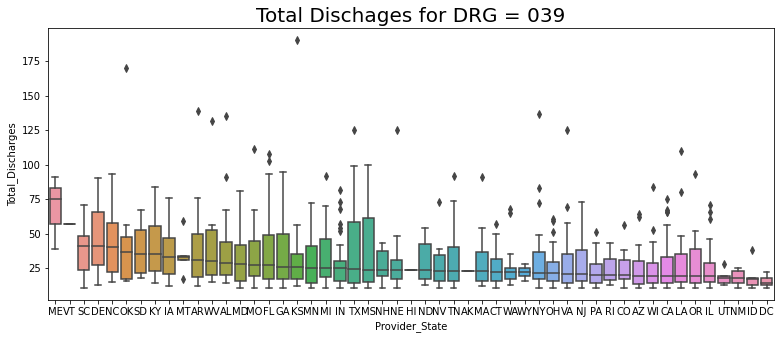

In [ ]:
# Visualize data with DRG 039(order by median)
data_039 = data[data["DRG"] == "039 - EXTRACRANIAL PROCEDURES W/O CC/MCC"]
sorted_index = data_039[['Provider_State', 'Total_Discharges']].groupby(by='Provider_State').median().sort_values(by='Total_Discharges',ascending=False).index
plt.figure(figsize=(13,5))
sns.boxplot(x="Provider_State", y="Total_Discharges",
            order = sorted_index, data=data_039)
plt.title('Total Dischages for DRG = 039',fontsize=20)

**`Findings:`**

Maine has the highest total discharges of treatment of *039 - EXTRACRANIAL PROCEDURES W/O CC/MCC* than other states. Washington DC has the lowest. There are huge variation of the number of discharges in many states.

We can also see that the number of discharges for the same treatment **varies from state to state**. 

In [ ]:
benchmark = data.groupby(['Provider_State','DRG'])['Total_Discharges'].mean().reset_index()
benchmark.columns = ['Provider_State','DRG','Ttl_Discharges_ByStateDRG']
benchmark.head()

,Provider_State,DRG,Ttl_Discharges_ByStateDRG
0,AK,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,23.000000
1,AK,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,11.000000
2,AK,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,22.500000
3,AK,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,25.333333
4,AK,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,21.000000


In [ ]:
# add to the dataset 
df3 = pd.merge(data, benchmark, how='left', on=['Provider_State', 'DRG'])
# Feature 3:
df3['DRG_state_totalDischarges_ratio_amount'] = np.where(df3['Ttl_Discharges_ByStateDRG']==0,0, df3['Total_Discharges'] / df3['Ttl_Discharges_ByStateDRG'])
df3['DRG_state_totalDischarges_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.686087
min           0.045025
25%           0.550452
50%           0.819820
75%           1.251471
max          24.624593
Name: DRG_state_totalDischarges_ratio_amount, dtype: float64

[Text(0, 0, '(0.044, 0.19]'),
 Text(0, 0, '(0.19, 0.384]'),
 Text(0, 0, '(0.384, 0.5]'),
 Text(0, 0, '(0.5, 0.82]'),
 Text(0, 0, '(0.82, 1.388]'),
 Text(0, 0, '(1.388, 1.824]'),
 Text(0, 0, '(1.824, 3.472]'),
 Text(0, 0, '(3.472, 24.625]')]

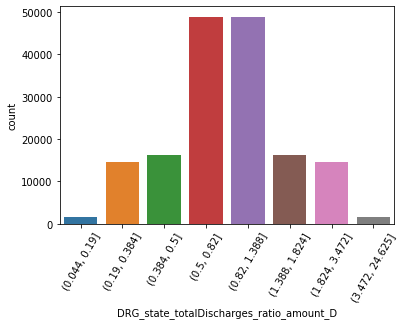

In [ ]:
# cut by percentile for plotting
var = 'DRG_state_totalDischarges_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.1,0.2,0.5,0.8,0.9,0.99,1]
df3[binned_var] = pd.qcut(df3[var],percentile)

# Visualization
g = sns.countplot(x="DRG_state_totalDischarges_ratio_amount_D", data=df3)
g.set_xticklabels(g.get_xticklabels(), rotation = 60)

Assuming that the top 10% of the DRG_state_totalDischarges_ratio_amount might be fraud, choose 1.8 as the threshold to filter out the following records.

In [ ]:
df3[df3['DRG_state_totalDischarges_ratio_amount']>1.8].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Ttl_Discharges_ByStateDRG,DRG_state_totalDischarges_ratio_amount,DRG_state_totalDischarges_ratio_amount_D
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,5777.24,4763.73,38.217391,2.381115,"(1.824, 3.472]"
8,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,AL,35801,AL - Huntsville,135,6113.38,5228.40,38.217391,3.532423,"(3.472, 24.625]"
35,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30061,BANNER BOSWELL MEDICAL CENTER,10401 WEST THUNDERBIRD BOULEVARD,SUN CITY,AZ,85351,AZ - Sun City,62,6048.61,4951.90,25.250000,2.455446,"(1.824, 3.472]"
47,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30105,BANNER HEART HOSPITAL,6750 EAST BAYWOOD AVENUE,MESA,AZ,85206,AZ - Mesa,64,6291.95,4788.12,25.250000,2.534653,"(1.824, 3.472]"
54,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,40027,BAXTER REGIONAL MEDICAL CENTER,624 HOSPITAL DRIVE,MOUNTAIN HOME,AR,72653,MO - Springfield,76,5496.31,4424.64,40.750000,1.865031,"(1.824, 3.472]"


## 2.4 ratio(mean(DRG_region)): Average_Total_Payments

**`Findings:`**

It is clear that the average total payment for the same treatment **varies from region to region**. Therefore, further discussion of location and treatment is necessary when comparing costs.

In [ ]:
benchmark = data.groupby(['Hospital_referral_region_desp','DRG'])['Average_Total_Payments'].mean().reset_index()
benchmark.columns = ['Hospital_referral_region_desp','DRG','Avg_Payment_ByRegionDRG']
benchmark.head()

,Hospital_referral_region_desp,DRG,Avg_Payment_ByRegionDRG
0,AK - Anchorage,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,8401.950000
1,AK - Anchorage,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,8799.000000
2,AK - Anchorage,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,21608.010000
3,AK - Anchorage,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,12555.548333
4,AK - Anchorage,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,9275.867500


In [ ]:
# add to the dataset 
df4 = pd.merge(data, benchmark, how='left', on=['Hospital_referral_region_desp', 'DRG'])
# Feature 4:
df4['DRG_Region_avg_ratio_amount'] = np.where(df4['Avg_Payment_ByRegionDRG']==0,0, df4['Average_Total_Payments'] / df4['Avg_Payment_ByRegionDRG'])
df4['DRG_Region_avg_ratio_amount'].describe()


count    163065.000000
mean          1.000000
std           0.159145
min           0.271255
25%           0.902856
50%           0.977701
75%           1.057561
max           4.848303
Name: DRG_Region_avg_ratio_amount, dtype: float64

[Text(0, 0, '(0.27, 0.734]'),
 Text(0, 0, '(0.734, 0.84]'),
 Text(0, 0, '(0.84, 0.885]'),
 Text(0, 0, '(0.885, 0.978]'),
 Text(0, 0, '(0.978, 1.085]'),
 Text(0, 0, '(1.085, 1.186]'),
 Text(0, 0, '(1.186, 1.544]'),
 Text(0, 0, '(1.544, 4.848]')]

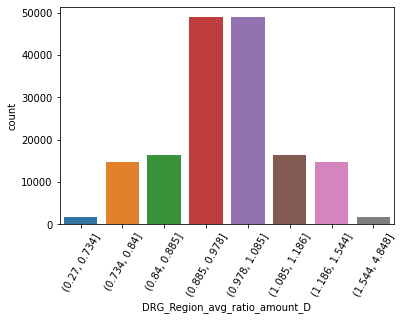

In [ ]:
# cut by percentile for plotting
var = 'DRG_Region_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.1,0.2,0.5,0.8,0.9,0.99,1]
df4[binned_var] = pd.qcut(df4[var],percentile)

# Visualization
g = sns.countplot(x="DRG_Region_avg_ratio_amount_D", data=df4)
g.set_xticklabels(g.get_xticklabels(), rotation = 60)

Assuming that the top 10% of the DRG_Region_avg_ratio_amount might be fraud, choose 1.15 as the threshold to filter out the following records.

In [ ]:
df4[df4['DRG_Region_avg_ratio_amount']>1.15].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Avg_Payment_ByRegionDRG,DRG_Region_avg_ratio_amount,DRG_Region_avg_ratio_amount_D
7,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10033,UNIVERSITY OF ALABAMA HOSPITAL,619 SOUTH 19TH STREET,BIRMINGHAM,AL,35233,AL - Birmingham,32,8031.12,5858.50,5738.564615,1.399500,"(1.186, 1.544]"
26,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30007,VERDE VALLEY MEDICAL CENTER,269 SOUTH CANDY LANE,COTTONWOOD,AZ,86326,AZ - Phoenix,18,9133.00,8008.11,7750.472000,1.178380,"(1.085, 1.186]"
31,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30023,FLAGSTAFF MEDICAL CENTER,1200 NORTH BEAVER STREET,FLAGSTAFF,AZ,86001,AZ - Phoenix,15,11026.33,9056.06,7750.472000,1.422666,"(1.186, 1.544]"
36,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30062,SUMMIT HEALTHCARE REGIONAL MEDICAL CENTER,2200 SHOW LOW LAKE ROAD,SHOW LOW,AZ,85901,AZ - Phoenix,17,10000.82,7321.64,7750.472000,1.290350,"(1.186, 1.544]"
59,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,40078,NATIONAL PARK MEDICAL CENTER,1910 MALVERN AVENUE,HOT SPRINGS,AR,71901,AR - Little Rock,18,9838.11,8533.83,6309.002222,1.559377,"(1.544, 4.848]"


## 2.5 ratio(mean(DRG_region)): Average_Medicare_Payment

**`Findings:`**

Same as the total payment, it is clear that the average total medical payment for the same treatment varies **from region to region**. Therefore, further discussion of location and treatment is necessary when comparing costs.

In [ ]:
benchmark = data.groupby(['Hospital_referral_region_desp','DRG'])['Average_Medicare_Payment'].mean().reset_index()
benchmark.columns = ['Hospital_referral_region_desp','DRG','Avg_Medicare_Payment_ByRegionDRG']
benchmark.head()

,Hospital_referral_region_desp,DRG,Avg_Medicare_Payment_ByRegionDRG
0,AK - Anchorage,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,6413.780000
1,AK - Anchorage,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,8081.540000
2,AK - Anchorage,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,20555.255000
3,AK - Anchorage,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,11140.963333
4,AK - Anchorage,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,8258.427500


In [ ]:
# add to the dataset 
df5 = pd.merge(data, benchmark, how='left', on=['Hospital_referral_region_desp', 'DRG'])
# Feature 5:
df5['DRG_Region_avg_ratio_Med'] = np.where(df5['Avg_Medicare_Payment_ByRegionDRG']==0,0, df5['Average_Medicare_Payment'] / df5['Avg_Medicare_Payment_ByRegionDRG'])
df5['DRG_Region_avg_ratio_Med'].describe()

count    163065.000000
mean          1.000000
std           0.175920
min           0.339831
25%           0.893506
50%           0.976954
75%           1.063344
max           4.516504
Name: DRG_Region_avg_ratio_Med, dtype: float64

[Text(0, 0, '(0.339, 0.7]'),
 Text(0, 0, '(0.7, 0.82]'),
 Text(0, 0, '(0.82, 0.873]'),
 Text(0, 0, '(0.873, 0.977]'),
 Text(0, 0, '(0.977, 1.093]'),
 Text(0, 0, '(1.093, 1.204]'),
 Text(0, 0, '(1.204, 1.613]'),
 Text(0, 0, '(1.613, 4.517]')]

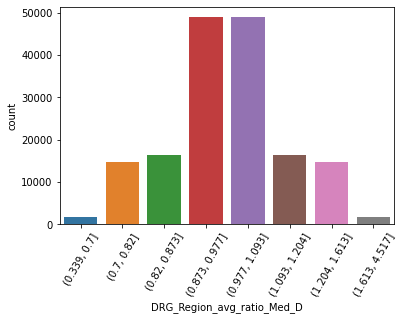

In [ ]:
# cut by percentile for plotting
var = 'DRG_Region_avg_ratio_Med'
binned_var = var + '_D'
percentile = [0,0.01,0.1,0.2,0.5,0.8,0.9,0.99,1]
df5[binned_var] = pd.qcut(df5[var],percentile)

# Visualization
g = sns.countplot(x="DRG_Region_avg_ratio_Med_D", data=df5)
g.set_xticklabels(g.get_xticklabels(), rotation = 60)

Assuming that the top 10% of the DRG_Region_avg_ratio_Med might be fraud, choose 1.19 as the threshold to filter out the following records.

In [ ]:
df5[df5['DRG_Region_avg_ratio_Med']>1.19].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Avg_Medicare_Payment_ByRegionDRG,DRG_Region_avg_ratio_Med,DRG_Region_avg_ratio_Med_D
7,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10033,UNIVERSITY OF ALABAMA HOSPITAL,619 SOUTH 19TH STREET,BIRMINGHAM,AL,35233,AL - Birmingham,32,8031.12,5858.50,4604.024615,1.272474,"(1.204, 1.613]"
26,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30007,VERDE VALLEY MEDICAL CENTER,269 SOUTH CANDY LANE,COTTONWOOD,AZ,86326,AZ - Phoenix,18,9133.00,8008.11,6447.728000,1.242005,"(1.204, 1.613]"
31,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30023,FLAGSTAFF MEDICAL CENTER,1200 NORTH BEAVER STREET,FLAGSTAFF,AZ,86001,AZ - Phoenix,15,11026.33,9056.06,6447.728000,1.404535,"(1.204, 1.613]"
59,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,40078,NATIONAL PARK MEDICAL CENTER,1910 MALVERN AVENUE,HOT SPRINGS,AR,71901,AR - Little Rock,18,9838.11,8533.83,5203.592222,1.639988,"(1.613, 4.517]"
73,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,50058,GLENDALE MEM HOSPITAL & HLTH CENTER,1420 S CENTRAL AVE,GLENDALE,CA,91204,CA - Los Angeles,11,11082.18,10056.00,7115.680000,1.413217,"(1.204, 1.613]"


## 2.6 ratio(mean(DRG_region)): Total_Discharges

**`Findings:`**

The variation of the total number of discharges is larger than the variation of the averge of the payments.

Also, the average total payment for the same treatment **varies from state to state**. Therefore, further discussion of location and treatment is necessary when comparing them.


In [ ]:
benchmark = data.groupby(['Hospital_referral_region_desp','DRG'])['Total_Discharges'].mean().reset_index()
benchmark.columns = ['Hospital_referral_region_desp','DRG','Ttl_Discharges_ByRegionDRG']
benchmark.head()

,Hospital_referral_region_desp,DRG,Ttl_Discharges_ByRegionDRG
0,AK - Anchorage,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,23.000000
1,AK - Anchorage,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,11.000000
2,AK - Anchorage,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,22.500000
3,AK - Anchorage,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,25.333333
4,AK - Anchorage,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,21.000000


In [ ]:
# add to the dataset 
df6 = pd.merge(data, benchmark, how='left', on=['Hospital_referral_region_desp', 'DRG'])
# Feature 6:
df6['DRG_Region_totalDischarges_ratio'] = np.where(df6['Ttl_Discharges_ByRegionDRG']==0,0, df6['Total_Discharges'] / df6['Ttl_Discharges_ByRegionDRG'])
df6['DRG_Region_totalDischarges_ratio'].describe()

count    163065.000000
mean          1.000000
std           0.596288
min           0.015412
25%           0.592105
50%           0.886894
75%           1.250000
max          11.008786
Name: DRG_Region_totalDischarges_ratio, dtype: float64

[Text(0, 0, '(0.0144, 0.2]'),
 Text(0, 0, '(0.2, 0.405]'),
 Text(0, 0, '(0.405, 0.535]'),
 Text(0, 0, '(0.535, 0.887]'),
 Text(0, 0, '(0.887, 1.369]'),
 Text(0, 0, '(1.369, 1.726]'),
 Text(0, 0, '(1.726, 3.086]'),
 Text(0, 0, '(3.086, 11.009]')]

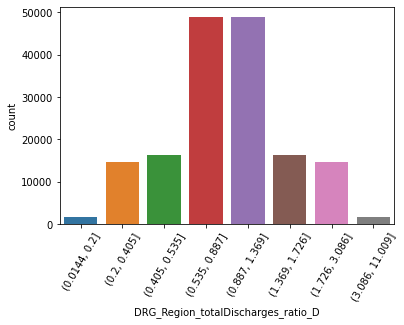

In [ ]:
# cut by percentile for plotting
var = 'DRG_Region_totalDischarges_ratio'
binned_var = var + '_D'
percentile = [0,0.01,0.1,0.2,0.5,0.8,0.9,0.99,1]
df6[binned_var] = pd.qcut(df6[var],percentile)

# Visualization
g = sns.countplot(x="DRG_Region_totalDischarges_ratio_D", data=df6)
g.set_xticklabels(g.get_xticklabels(), rotation = 60)

Assuming that the top 10% of the DRG_Region_totalDischarges_ratio_ might be fraud, choose 1.7 as the threshold to filter out the following records.

In [ ]:
df6[df6['DRG_Region_totalDischarges_ratio']>1.7].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Ttl_Discharges_ByRegionDRG,DRG_Region_totalDischarges_ratio,DRG_Region_totalDischarges_ratio_D
6,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10029,EAST ALABAMA MEDICAL CENTER AND SNF,2000 PEPPERELL PARKWAY,OPELIKA,AL,36801,AL - Birmingham,51,5834.74,4761.41,27.461538,1.857143,"(1.726, 3.086]"
21,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10113,MOBILE INFIRMARY,5 MOBILE INFIRMARY CIRCLE,MOBILE,AL,36652,AL - Mobile,66,5550.90,4219.90,30.000000,2.200000,"(1.726, 3.086]"
33,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30030,PHOENIX BAPTIST HOSPITAL,2000 WEST BETHANY HOME ROAD,PHOENIX,AZ,85015,AZ - Phoenix,42,7673.21,6541.92,20.600000,2.038835,"(1.726, 3.086]"
38,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30069,HAVASU REGIONAL MEDICAL CENTER,101 CIVIC CENTER LANE,LAKE HAVASU CIT,AZ,86403,AZ - Phoenix,36,6605.19,5665.41,20.600000,1.747573,"(1.726, 3.086]"
60,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,40114,BAPTIST HEALTH MEDICAL CENTER-LITTLE ROCK,"9601 INTERSTATE 630, EXIT 7",LITTLE ROCK,AR,72205,AR - Little Rock,139,5968.44,4592.46,45.555556,3.051220,"(1.726, 3.086]"


## 2.7 ratio(mean(DRG_region)): Total_Payments

In [ ]:
data['Total_Payments'] = data['Average_Total_Payments'] * data['Total_Discharges']
benchmark = data.groupby(['Hospital_referral_region_desp','DRG'])['Total_Payments'].mean().reset_index()
benchmark.columns = ['Hospital_referral_region_desp','DRG','Ttl_Payments_ByRegionDRG']
benchmark.head()

,Hospital_referral_region_desp,DRG,Ttl_Payments_ByRegionDRG
0,AK - Anchorage,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,193244.850000
1,AK - Anchorage,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,96789.000000
2,AK - Anchorage,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,442077.840000
3,AK - Anchorage,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,306366.171667
4,AK - Anchorage,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,184201.692500


In [ ]:
# add to the dataset 
df7 = pd.merge(data, benchmark, how='left', on=['Hospital_referral_region_desp', 'DRG'])
# Feature 7:
df7['DRG_Region_totalPayment_ratio'] = np.where(df7['Ttl_Payments_ByRegionDRG']==0,0, df7['Total_Payments'] / df7['Ttl_Payments_ByRegionDRG'])
df7['DRG_Region_totalPayment_ratio'].describe()

count    163065.000000
mean          1.000000
std           0.640183
min           0.014374
25%           0.564201
50%           0.869294
75%           1.250038
max          10.197440
Name: DRG_Region_totalPayment_ratio, dtype: float64

[Text(0, 0, '(0.013399999999999999, 0.187]'),
 Text(0, 0, '(0.187, 0.381]'),
 Text(0, 0, '(0.381, 0.507]'),
 Text(0, 0, '(0.507, 0.869]'),
 Text(0, 0, '(0.869, 1.378]'),
 Text(0, 0, '(1.378, 1.771]'),
 Text(0, 0, '(1.771, 3.291]'),
 Text(0, 0, '(3.291, 10.197]')]

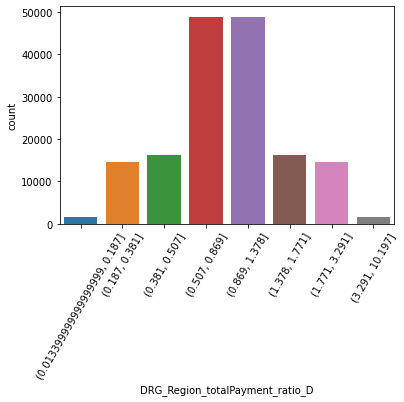

In [ ]:
# cut by percentile for plotting
var = 'DRG_Region_totalPayment_ratio'
binned_var = var + '_D'
percentile = [0,0.01,0.1,0.2,0.5,0.8,0.9,0.99,1]
df7[binned_var] = pd.qcut(df7[var],percentile)

# Visualization
g = sns.countplot(x="DRG_Region_totalPayment_ratio_D", data=df7)
g.set_xticklabels(g.get_xticklabels(), rotation = 60)

Assuming that the top 10% of the DRG_Region_totalPayment_ratio_ might be fraud, choose 1.75 as the threshold to filter out the following records.

In [ ]:
df7[df7['DRG_Region_totalPayment_ratio']>1.75].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Total_Payments,Ttl_Payments_ByRegionDRG,DRG_Region_totalPayment_ratio,DRG_Region_totalPayment_ratio_D
6,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10029,EAST ALABAMA MEDICAL CENTER AND SNF,2000 PEPPERELL PARKWAY,OPELIKA,AL,36801,AL - Birmingham,51,5834.74,4761.41,297571.74,159246.514615,1.868623,"(1.771, 3.291]"
21,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10113,MOBILE INFIRMARY,5 MOBILE INFIRMARY CIRCLE,MOBILE,AL,36652,AL - Mobile,66,5550.90,4219.90,366359.40,166715.664000,2.197510,"(1.771, 3.291]"
33,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30030,PHOENIX BAPTIST HOSPITAL,2000 WEST BETHANY HOME ROAD,PHOENIX,AZ,85015,AZ - Phoenix,42,7673.21,6541.92,322274.82,156931.058667,2.053608,"(1.771, 3.291]"
60,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,40114,BAPTIST HEALTH MEDICAL CENTER-LITTLE ROCK,"9601 INTERSTATE 630, EXIT 7",LITTLE ROCK,AR,72205,AR - Little Rock,139,5968.44,4592.46,829613.16,273109.015556,3.037663,"(1.771, 3.291]"
72,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,50057,KAWEAH DELTA MEDICAL CENTER,400 W MINERAL KING AVE,VISALIA,CA,93291,CA - Bakersfield,52,7562.26,6247.48,393237.52,213011.446667,1.846086,"(1.771, 3.291]"


## 2.8 ratio(mean(DRG_State)): Total_Payments

Text(0.5, 1.0, 'Avg. Total Payments for DRG = 039')

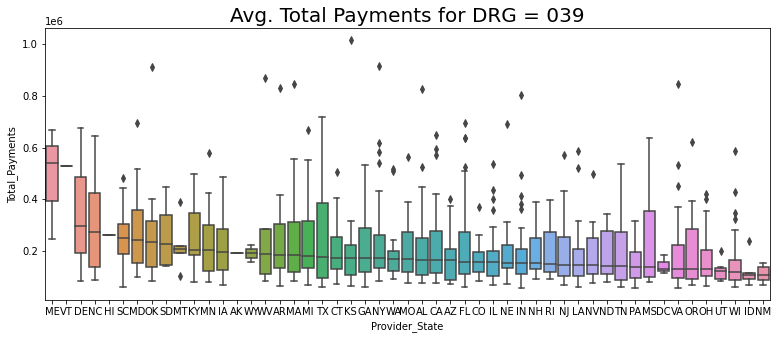

In [ ]:
# Visualize data with DRG 039(order by median)
data_039 = data[data["DRG"] == "039 - EXTRACRANIAL PROCEDURES W/O CC/MCC"]
sorted_index = data_039[['Provider_State', 'Total_Payments']].groupby(by='Provider_State').median().sort_values(by='Total_Payments',ascending=False).index
plt.figure(figsize=(13,5))
sns.boxplot(x="Provider_State", y="Total_Payments",
            order = sorted_index, data=data_039)
plt.title('Avg. Total Payments for DRG = 039',fontsize=20)

**`Findings:`**

Maine has the highest cost of treatment of *039 - EXTRACRANIAL PROCEDURES W/O CC/MCC* than other states. New Mexico has the lowest. There are huge variation of the price in many states.

Also, the total payment for the same treatment **varies from state to state**. Therefore, further discussion of location and treatment is necessary when comparing costs.

In [ ]:
benchmark = data.groupby(['Provider_State','DRG'])['Total_Payments'].mean().reset_index()
benchmark.columns = ['Provider_State','DRG','Ttl_Payments_ByStateDRG']
benchmark.head()

,Provider_State,DRG,Ttl_Payments_ByStateDRG
0,AK,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,193244.850000
1,AK,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,96789.000000
2,AK,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,442077.840000
3,AK,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,306366.171667
4,AK,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,184201.692500


In [ ]:
# add to the dataset 
df8 = pd.merge(data, benchmark, how='left', on=['Provider_State', 'DRG'])
# Feature 1:
df8['DRG_State_totalPayment_ratio'] = np.where(df8['Ttl_Payments_ByStateDRG']==0,0, df8['Total_Payments'] / df8['Ttl_Payments_ByStateDRG'])
df8['DRG_State_totalPayment_ratio'].describe()

count    163065.000000
mean          1.000000
std           0.748733
min           0.030374
25%           0.519497
50%           0.796641
75%           1.249406
max          27.414513
Name: DRG_State_totalPayment_ratio, dtype: float64

[Text(0, 0, '(0.0294, 0.174]'),
 Text(0, 0, '(0.174, 0.354]'),
 Text(0, 0, '(0.354, 0.469]'),
 Text(0, 0, '(0.469, 0.797]'),
 Text(0, 0, '(0.797, 1.395]'),
 Text(0, 0, '(1.395, 1.871]'),
 Text(0, 0, '(1.871, 3.767]'),
 Text(0, 0, '(3.767, 27.415]')]

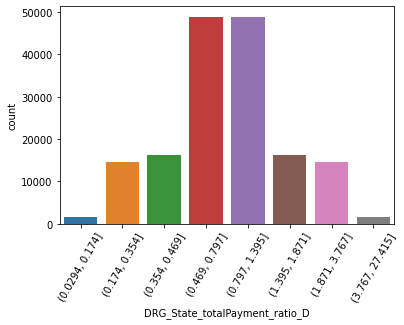

In [ ]:
# cut by percentile for plotting
var = 'DRG_State_totalPayment_ratio'
binned_var = var + '_D'
percentile = [0,0.01,0.1,0.2,0.5,0.8,0.9,0.99,1]
df8[binned_var] = pd.qcut(df8[var],percentile)

# Visualization
g = sns.countplot(x="DRG_State_totalPayment_ratio_D", data=df8)
g.set_xticklabels(g.get_xticklabels(), rotation = 60)

Assuming that the top 10% of the DRG_State_totalPayment_ratio might be fraud, choose 1.85 as the threshold to filter out the following records.

In [ ]:
df8[df8['DRG_State_totalPayment_ratio']>1.85].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Total_Payments,Ttl_Payments_ByStateDRG,DRG_State_totalPayment_ratio,DRG_State_totalPayment_ratio_D
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,5777.24,4763.73,525728.84,223845.78,2.348621,"(1.871, 3.767]"
5,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10023,BAPTIST MEDICAL CENTER SOUTH,2105 EAST SOUTH BOULEVARD,MONTGOMERY,AL,36116,AL - Montgomery,67,6653.80,5374.14,445804.60,223845.78,1.991570,"(1.871, 3.767]"
8,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,AL,35801,AL - Huntsville,135,6113.38,5228.40,825306.30,223845.78,3.686942,"(1.871, 3.767]"
35,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30061,BANNER BOSWELL MEDICAL CENTER,10401 WEST THUNDERBIRD BOULEVARD,SUN CITY,AZ,85351,AZ - Sun City,62,6048.61,4951.90,375013.82,177620.58,2.111320,"(1.871, 3.767]"
47,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30105,BANNER HEART HOSPITAL,6750 EAST BAYWOOD AVENUE,MESA,AZ,85206,AZ - Mesa,64,6291.95,4788.12,402684.80,177620.58,2.267107,"(1.871, 3.767]"


## 2.9 ratio(mean(DRG)): Total_Discharges

In the above EDA, I primarily compared the number of discharges in the states of the same treatment. However, I think it is also necessary to compare **the number of discharges only for the same treatment.** In this case, the feature can detect the differences for each provider and thus detect partial insurance fraud for a particular disease. 

In [ ]:
benchmark = data.groupby(['DRG'])['Total_Discharges'].mean().reset_index()
benchmark.columns = ['DRG','Avg_Discharges_ByDRG']
benchmark.head()

,DRG,Avg_Discharges_ByDRG
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,31.145505
1,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,25.155704
2,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,37.427969
3,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,46.899074
4,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,30.924142


In [ ]:
# add to the dataset 
df9 = pd.merge(data, benchmark, how='left', on=['DRG'])
# Feature 9:
df9['DRG_ToTalDischarges_ratio'] = np.where(df9['Avg_Discharges_ByDRG']==0,0, df9['Total_Discharges'] / df9['Avg_Discharges_ByDRG'])
df9['DRG_ToTalDischarges_ratio'].describe()

count    163065.000000
mean          1.000000
std           0.760072
min           0.070809
25%           0.523420
50%           0.788843
75%           1.238076
max          44.569469
Name: DRG_ToTalDischarges_ratio, dtype: float64

[Text(0, 0, '(0.0698, 0.183]'),
 Text(0, 0, '(0.183, 0.365]'),
 Text(0, 0, '(0.365, 0.476]'),
 Text(0, 0, '(0.476, 0.789]'),
 Text(0, 0, '(0.789, 1.388]'),
 Text(0, 0, '(1.388, 1.881]'),
 Text(0, 0, '(1.881, 3.791]'),
 Text(0, 0, '(3.791, 44.569]')]

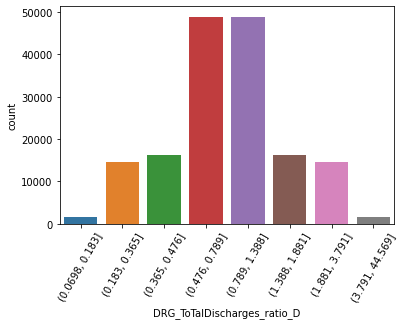

In [ ]:
# cut by percentile for plotting
var = 'DRG_ToTalDischarges_ratio'
binned_var = var + '_D'
percentile = [0,0.01,0.1,0.2,0.5,0.8,0.9,0.99,1]
df9[binned_var] = pd.qcut(df9[var],percentile)

# Visualization
g = sns.countplot(x="DRG_ToTalDischarges_ratio_D", data=df9)
g.set_xticklabels(g.get_xticklabels(), rotation = 60)

Assuming that the top 10% of the DRG_ToTalDischarges_ratio might be fraud, choose 1.85 as the threshold to filter out the following records.

In [ ]:
df9[df9['DRG_ToTalDischarges_ratio']>1.85].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Total_Payments,Avg_Discharges_ByDRG,DRG_ToTalDischarges_ratio,DRG_ToTalDischarges_ratio_D
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,5777.24,4763.73,525728.84,31.145505,2.921770,"(1.881, 3.791]"
5,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10023,BAPTIST MEDICAL CENTER SOUTH,2105 EAST SOUTH BOULEVARD,MONTGOMERY,AL,36116,AL - Montgomery,67,6653.80,5374.14,445804.60,31.145505,2.151193,"(1.881, 3.791]"
8,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,AL,35801,AL - Huntsville,135,6113.38,5228.40,825306.30,31.145505,4.334494,"(3.791, 44.569]"
21,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10113,MOBILE INFIRMARY,5 MOBILE INFIRMARY CIRCLE,MOBILE,AL,36652,AL - Mobile,66,5550.90,4219.90,366359.40,31.145505,2.119086,"(1.881, 3.791]"
35,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30061,BANNER BOSWELL MEDICAL CENTER,10401 WEST THUNDERBIRD BOULEVARD,SUN CITY,AZ,85351,AZ - Sun City,62,6048.61,4951.90,375013.82,31.145505,1.990656,"(1.881, 3.791]"


## 2.10 ratio(mean(DRG_State)): Coverage

Text(0.5, 1.0, 'Avg. Total Payments for DRG = 039')

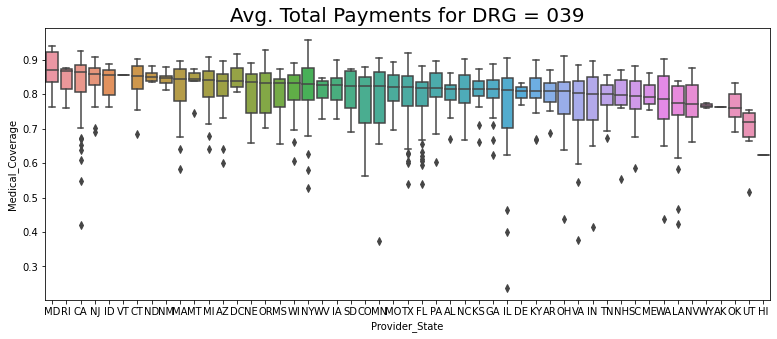

In [ ]:
data['Medical_Coverage'] = data['Average_Medicare_Payment'] / data['Average_Total_Payments']

# Visualize data with DRG 039(order by median)
data_039 = data[data["DRG"] == "039 - EXTRACRANIAL PROCEDURES W/O CC/MCC"]
sorted_index = data_039[['Provider_State', 'Medical_Coverage']].groupby(by='Provider_State').median().sort_values(by='Medical_Coverage',ascending=False).index
plt.figure(figsize=(13,5))
sns.boxplot(x="Provider_State", y="Medical_Coverage",
            order = sorted_index, data=data_039)
plt.title('Avg. Total Payments for DRG = 039',fontsize=20)

**`Findings:`**

Maryland has the highest medical coverage of treatment of *039 - EXTRACRANIAL PROCEDURES W/O CC/MCC* than other states. Hawaii has the lowest.

In [ ]:
benchmark = data.groupby(['Provider_State','DRG'])['Medical_Coverage'].mean().reset_index()
benchmark.columns = ['Provider_State','DRG','Coverage_ByDRGState']
benchmark.head()

,Provider_State,DRG,Coverage_ByDRGState
0,AK,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,0.763368
1,AK,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,0.918461
2,AK,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,0.949494
3,AK,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,0.881871
4,AK,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,0.885247


In [ ]:
# add to the dataset 
df10 = pd.merge(data, benchmark, how='left', on=['Provider_State', 'DRG'])
# Feature 10:
df10['DRG_State_Coverage_ratio'] = np.where(df10['Coverage_ByDRGState']==0,0, df10['Medical_Coverage'] / df10['Coverage_ByDRGState'])
df10['DRG_State_Coverage_ratio'].describe()

count    163065.000000
mean          1.000000
std           0.076404
min           0.057747
25%           0.973334
50%           1.012873
75%           1.041892
max           1.381868
Name: DRG_State_Coverage_ratio, dtype: float64

[Text(0, 0, '(0.0567, 0.726]'),
 Text(0, 0, '(0.726, 0.913]'),
 Text(0, 0, '(0.913, 0.959]'),
 Text(0, 0, '(0.959, 1.013]'),
 Text(0, 0, '(1.013, 1.05]'),
 Text(0, 0, '(1.05, 1.073]'),
 Text(0, 0, '(1.073, 1.145]'),
 Text(0, 0, '(1.145, 1.382]')]

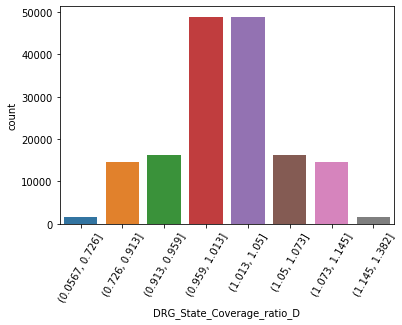

In [ ]:
# cut by percentile for plotting
var = 'DRG_State_Coverage_ratio'
binned_var = var + '_D'
percentile = [0,0.01,0.1,0.2,0.5,0.8,0.9,0.99,1]
df10[binned_var] = pd.qcut(df10[var],percentile)

# Visualization
g = sns.countplot(x="DRG_State_Coverage_ratio_D", data=df10)
g.set_xticklabels(g.get_xticklabels(), rotation = 60)

Assuming that the top 10% of the DRG_State_Coverage_ratio might be fraud, choose 1.07 as the threshold to filter out the following records.

In [ ]:
df10[df10['DRG_State_Coverage_ratio']>1.07].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Total_Payments,Medical_Coverage,Coverage_ByDRGState,DRG_State_Coverage_ratio,DRG_State_Coverage_ratio_D
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,5787.57,4976.71,81025.98,0.859896,0.801778,1.072487,"(1.05, 1.073]"
24,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30002,BANNER GOOD SAMARITAN MEDICAL CENTER,1111 EAST MCDOWELL ROAD,PHOENIX,AZ,85006,AZ - Phoenix,11,7768.90,6951.45,85457.90,0.894779,0.812757,1.100919,"(1.073, 1.145]"
26,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30007,VERDE VALLEY MEDICAL CENTER,269 SOUTH CANDY LANE,COTTONWOOD,AZ,86326,AZ - Phoenix,18,9133.00,8008.11,164394.00,0.876832,0.812757,1.078838,"(1.073, 1.145]"
32,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30024,ST JOSEPH'S HOSPITAL AND MEDICAL CENTER,350 WEST THOMAS ROAD,PHOENIX,AZ,85013,AZ - Phoenix,18,8487.44,7422.66,152773.92,0.874546,0.812757,1.076025,"(1.073, 1.145]"
42,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30093,BANNER DEL E WEBB MEDICAL CENTER,14502 WEST MEEKER BOULEVARD,SUN CITY WEST,AZ,85375,AZ - Sun City,12,6061.50,5312.16,72738.00,0.876377,0.812757,1.078277,"(1.073, 1.145]"


## 2.11 ratio(mean(DRG_region)): Medical_Coverage

In [ ]:
benchmark = data.groupby(['Hospital_referral_region_desp','DRG'])['Medical_Coverage'].mean().reset_index()
benchmark.columns = ['Hospital_referral_region_desp','DRG','Coverage_ByDRGRegion']
benchmark.head()

,Hospital_referral_region_desp,DRG,Coverage_ByDRGRegion
0,AK - Anchorage,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,0.763368
1,AK - Anchorage,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,0.918461
2,AK - Anchorage,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,0.949494
3,AK - Anchorage,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,0.881871
4,AK - Anchorage,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,0.885247


In [ ]:
# add to the dataset 
df11 = pd.merge(data, benchmark, how='left', on=['Hospital_referral_region_desp', 'DRG'])
# Feature 11:
df11['DRG_Region_Coverage_ratio'] = np.where(df11['Coverage_ByDRGRegion']==0,0, df11['Medical_Coverage'] / df11['Coverage_ByDRGRegion'])
df11['DRG_Region_Coverage_ratio'].describe()

count    163065.000000
mean          1.000000
std           0.070109
min           0.075390
25%           0.975894
50%           1.006247
75%           1.035994
max           1.653654
Name: DRG_Region_Coverage_ratio, dtype: float64

[Text(0, 0, '(0.0744, 0.755]'),
 Text(0, 0, '(0.755, 0.924]'),
 Text(0, 0, '(0.924, 0.964]'),
 Text(0, 0, '(0.964, 1.006]'),
 Text(0, 0, '(1.006, 1.044]'),
 Text(0, 0, '(1.044, 1.068]'),
 Text(0, 0, '(1.068, 1.153]'),
 Text(0, 0, '(1.153, 1.654]')]

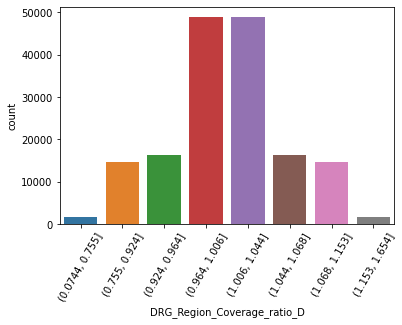

In [ ]:
# cut by percentile for plotting
var = 'DRG_Region_Coverage_ratio'
binned_var = var + '_D'
percentile = [0,0.01,0.1,0.2,0.5,0.8,0.9,0.99,1]
df11[binned_var] = pd.qcut(df11[var],percentile)

# Visualization
g = sns.countplot(x="DRG_Region_Coverage_ratio_D", data=df11)
g.set_xticklabels(g.get_xticklabels(), rotation = 60)

Assuming that the top 10% of the DRG_Region_Coverage_ratio might be fraud, choose 1.06 as the threshold to filter out the following records.

In [ ]:
df11[df11['DRG_Region_Coverage_ratio']>1.06].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Total_Payments,Medical_Coverage,Coverage_ByDRGRegion,DRG_Region_Coverage_ratio,DRG_Region_Coverage_ratio_D
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,5787.57,4976.71,81025.98,0.859896,0.804224,1.069224,"(1.068, 1.153]"
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,5658.33,4851.44,101849.94,0.857398,0.804224,1.066118,"(1.044, 1.068]"
14,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10083,SOUTH BALDWIN REGIONAL MEDICAL CENTER,1613 NORTH MCKENZIE STREET,FOLEY,AL,36535,AL - Mobile,15,5282.93,4383.73,79243.95,0.829791,0.776428,1.068729,"(1.068, 1.153]"
24,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30002,BANNER GOOD SAMARITAN MEDICAL CENTER,1111 EAST MCDOWELL ROAD,PHOENIX,AZ,85006,AZ - Phoenix,11,7768.90,6951.45,85457.90,0.894779,0.834139,1.072698,"(1.068, 1.153]"
25,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30006,TUCSON MEDICAL CENTER,5301 EAST GRANT ROAD,TUCSON,AZ,85712,AZ - Tucson,40,6799.85,5764.87,271994.00,0.847794,0.770465,1.100366,"(1.068, 1.153]"


# 3. Merge

After creating the features, they need to be merged into the same table for modeling purposes.

In [ ]:
df_final = pd.merge(data,df1['DRG_state_avg_ratio_amount'],how='left', left_index=True, right_index=True).\
              merge(df2['DRG_state_avg_ratio_amount_medicare'],how='left', left_index=True, right_index=True).\
              merge(df3['DRG_state_totalDischarges_ratio_amount'],how='left', left_index=True, right_index=True).\
              merge(df4['DRG_Region_avg_ratio_amount'],how='left', left_index=True, right_index=True).\
              merge(df5['DRG_Region_avg_ratio_Med'],how='left', left_index=True, right_index=True).\
              merge(df6['DRG_Region_totalDischarges_ratio'],how='left', left_index=True, right_index=True).\
              merge(df7['DRG_Region_totalPayment_ratio'],how='left', left_index=True, right_index=True).\
              merge(df8['DRG_State_totalPayment_ratio'],how='left', left_index=True, right_index=True).\
              merge(df9['DRG_ToTalDischarges_ratio'],how='left', left_index=True, right_index=True).\
              merge(df10['DRG_State_Coverage_ratio'],how='left', left_index=True, right_index=True).\
              merge(df11['DRG_Region_Coverage_ratio'],how='left', left_index=True, right_index=True)

# 4. Modeling

**Steps:**

1.   Merge 11 features
2.   Standardize and split dataset into training and testing
3.   Autoencoder
4.   Apply models and clustering results
5.   Apply Isolated Forest method
6.   Standardize the output values
6.   Aggregating
7.   Analysis

In [ ]:
# Check columns' name and enable to select them by names
df_final.columns

Index(['DRG', 'Provider_Id', 'Provider_Name', 'Provider_StreetAddress',
       'Provider_City', 'Provider_State', 'Provider_Zipcode',
       'Hospital_referral_region_desp', 'Total_Discharges',
       'Average_Total_Payments', 'Average_Medicare_Payment', 'Total_Payments',
       'Medical_Coverage', 'DRG_state_avg_ratio_amount',
       'DRG_state_avg_ratio_amount_medicare',
       'DRG_state_totalDischarges_ratio_amount', 'DRG_Region_avg_ratio_amount',
       'DRG_Region_avg_ratio_Med', 'DRG_Region_totalDischarges_ratio',
       'DRG_Region_totalPayment_ratio', 'DRG_State_totalPayment_ratio',
       'DRG_ToTalDischarges_ratio', 'DRG_State_Coverage_ratio',
       'DRG_Region_Coverage_ratio'],
      dtype='object')

## 4.1 Select features

In [ ]:
# Only keep the 11 features
df_final = df_final.drop(['DRG', 'Provider_Id', 'Provider_Name', 'Provider_StreetAddress',
       'Provider_City', 'Provider_State', 'Provider_Zipcode',
       'Hospital_referral_region_desp', 'Total_Discharges',
       'Average_Total_Payments', 'Average_Medicare_Payment', 'Total_Payments',
       'Medical_Coverage'], axis=1)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 11 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   DRG_state_avg_ratio_amount              163065 non-null  float64
 1   DRG_state_avg_ratio_amount_medicare     163065 non-null  float64
 2   DRG_state_totalDischarges_ratio_amount  163065 non-null  float64
 3   DRG_Region_avg_ratio_amount             163065 non-null  float64
 4   DRG_Region_avg_ratio_Med                163065 non-null  float64
 5   DRG_Region_totalDischarges_ratio        163065 non-null  float64
 6   DRG_Region_totalPayment_ratio           163065 non-null  float64
 7   DRG_State_totalPayment_ratio            163065 non-null  float64
 8   DRG_ToTalDischarges_ratio               163065 non-null  float64
 9   DRG_State_Coverage_ratio                163065 non-null  float64
 10  DRG_Region_Coverage_ratio               1630

## 4.2 Split & Standardize

In [ ]:
# Split Data
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df_final,random_state=0)

# Standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
scaler.fit(X_train)    # Only the training data are used to fit the scaler transformation
X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)  # then the scaler is used to transform the test input data.
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled)

## 4.3 Method: Autoencoder

**What is Autoencoder?**

An autoencoder is an unsupervised model and a type of neural network that encodes input values into a significant hidden layer and decodes them into the output layer. The hidden layer(s) is obtained by compressing the information and therefore should contain fewer dimensions than the input and output layers, presenting a symmetric structure. 

**Application:**

This method was applied in the early days for dimensionality reduction, and recently autoencoders have also been used as a technique for converting black and white images to color, or for reducing noise in photographs.

**Advantages:**

Autoencoders are suitable for solving complex non-linear problems because they can transform data efficiently using their activation functions and multiple layers.

### 4.3.1 Build the Model

* Model 1: [11, 2, 2, 11].

The input layer and the output 
layer has 11 neurons each. There are two hidden layers, each has two neurons.

* Model 2: [11, 5, 2, 5, 11].

Besides the input layer and output layers, there are three hidden layers with 5, 2, and 5 neurons respectively.


* Model 3: [11, 8, 5, 2, 5, 8, 11]. 

There are five hidden layers with 8, 5, 2, 5, 8 neurons respectively.

#### Model 1: [11, 2, 2, 11]

In [ ]:
! pip install pyod

In [ ]:
from pyod.models.auto_encoder import AutoEncoder
clf1 = AutoEncoder(hidden_neurons =[11, 2, 2, 11])
clf1.fit(X_train_scaled)

In [ ]:
# raw outlier scores
y_train_scores = clf1.decision_scores_  

# get the prediction on the test data
y_test_pred = clf1.predict(X_test_scaled)  # outlier labels (0 or 1)
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf1.decision_function(X_test_scaled)  # outlier scores

y_test_pred = pd.Series(y_test_pred)
y_test_scores = pd.Series(y_test_scores)

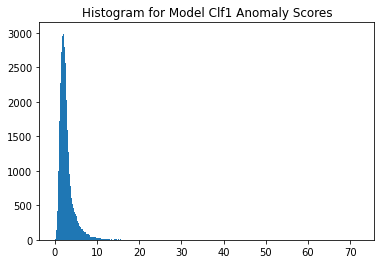

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

In [ ]:
df_test = X_test_scaled.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<8, 0, 1)
df_test['cluster'].value_counts()

df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,score
cluster,,,,,,,,,,,,
0,-0.051556,-0.041668,-0.050493,-0.050043,-0.040429,-0.047378,-0.058183,-0.062969,-0.048272,0.006658,0.006898,2.603913
1,2.338597,1.790300,2.586235,2.262287,1.726996,2.457011,3.004011,3.207459,2.494238,-0.550972,-0.583552,10.729413


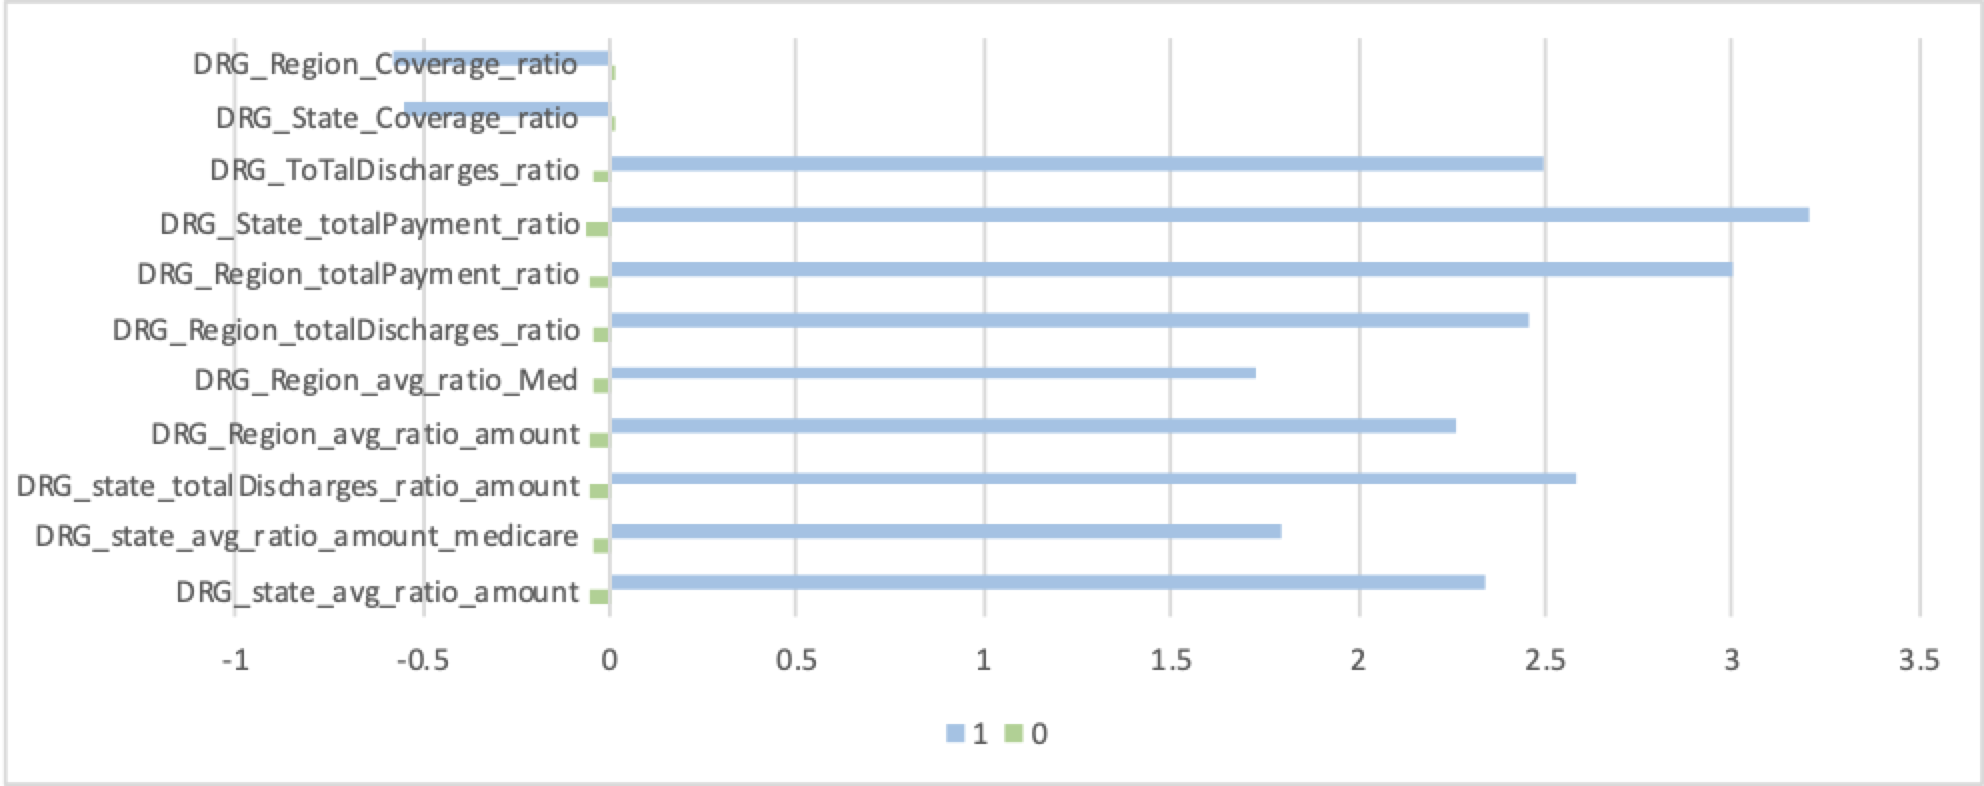

As can be seen by the above results, two clusters were filtered out when the threshold value of scores was set to be greater than 8. Among them, the average of scores within cluster 0 is about 2.60, while the sum of scores of each bins within cluster 1 is 10.73, which is much larger than 2.60. Therefore, according to the definition of the Autoencoder algorithm, it is known that cluster 1 are outliers.

In addition, it is not difficult to find that the average of score of cluster1 under each features is significantly larger than that of cluster0. It indicates that this is a good modeling and no modification is needed for individual features.

In [ ]:
cluster_0 = df_test[df_test['cluster']==0]['cluster'].count() / df_test['cluster'].count() * 100
cluster_0

98.16272965879264

In [ ]:
culster_1 = df_test[df_test['cluster']==1]['cluster'].count() / df_test['cluster'].count() * 100
culster_1

1.837270341207349

When the threshold value of the average of scores was set to be greater than 8, there are 1.84% of the test dataset are outliers.

#### Model 2: [11, 5, 2, 5, 11]

In [ ]:
clf2 = AutoEncoder(hidden_neurons = [11, 5, 2, 5, 11])
clf2.fit(X_train_scaled)

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf2.decision_function(X_test_scaled)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

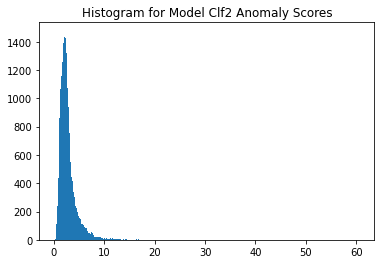

In [ ]:
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model Clf2 Anomaly Scores")
plt.show()

In [ ]:
df_test = X_test_scaled.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<8, 0, 1)
df_test['cluster'].value_counts()

df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,score
cluster,,,,,,,,,,,,
0,-0.051556,-0.041668,-0.050493,-0.050043,-0.040429,-0.047378,-0.058183,-0.062969,-0.048272,0.006658,0.006898,2.604005
1,2.338597,1.790300,2.586235,2.262287,1.726996,2.457011,3.004011,3.207459,2.494238,-0.550972,-0.583552,10.729027


The result is similar to the model 1. 

The average of scores within cluster 0 is about 2.60, while the sum of scores of each bins within cluster 1 is 10.7290, which is much larger than 2.60. Therefore, according to the definition of the Autoencoder algorithm, it is known that cluster 1 are outliers.

In [ ]:
cluster_0 = df_test[df_test['cluster']==0]['cluster'].count() / df_test['cluster'].count() * 100
cluster_0

98.16272965879264

In [ ]:
culster_1 = df_test[df_test['cluster']==1]['cluster'].count() / df_test['cluster'].count() * 100
culster_1

1.837270341207349

When the threshold value of the average of scores was set to be greater than 8, there are 1.84% of the test dataset are outliers.

#### Model 3: [11, 8, 5, 2, 5, 8, 11]

In [ ]:
clf3 = AutoEncoder(hidden_neurons =[11, 8, 5, 2, 5, 8, 11])
clf3.fit(X_train_scaled)

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf3.decision_function(X_test_scaled)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

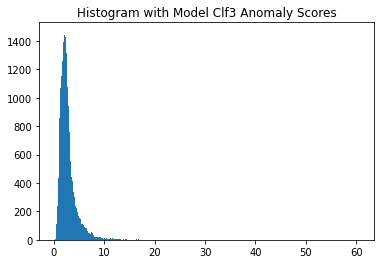

In [ ]:
plt.hist(y_test_scores, bins='auto')  
plt.title("Histogram with Model Clf3 Anomaly Scores")
plt.show()

In [ ]:
df_test = X_test_scaled.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<8, 0, 1)
df_test['cluster'].value_counts()
df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,score
cluster,,,,,,,,,,,,
0,-0.051556,-0.041668,-0.050493,-0.050043,-0.040429,-0.047378,-0.058183,-0.062969,-0.048272,0.006658,0.006898,2.603993
1,2.338597,1.790300,2.586235,2.262287,1.726996,2.457011,3.004011,3.207459,2.494238,-0.550972,-0.583552,10.729067


The result is similar to the model 1 and model 2.

The average of scores within cluster 0 is about 2.60, while the sum of scores of each bins within cluster 1 is 10.729067, which is much larger than 2.60. Therefore, according to the definition of the Autoencoder algorithm, it is known that cluster 1 are outliers.

In [ ]:
cluster_0 = df_test[df_test['cluster']==0]['cluster'].count() / df_test['cluster'].count() * 100
cluster_0

98.16272965879264

In [ ]:
culster_1 = df_test[df_test['cluster']==1]['cluster'].count() / df_test['cluster'].count() * 100
culster_1

1.837270341207349

When the threshold value of the average of scores was set to be greater than 8, there are 1.84% of the test dataset are outliers.

# 5. Aggregating Models

Unsupervised techniques are powerful tools in detecting outliners, but they also prone to overfitting. Therefore, I will use the 4 following methods to train and aggregate the models.

In [ ]:
!pip install combo

In [ ]:
from pyod.models.combination import aom, moa, average, maximization

# Put all the predictions in a data frame
train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_
                            })

test_scores  = pd.DataFrame({'clf1': clf1.decision_function(X_test_scaled),
                             'clf2': clf2.decision_function(X_test_scaled),
                             'clf3': clf3.decision_function(X_test_scaled) 
                            })

In [ ]:
# standardization for the decision scores
from pyod.utils.utility import standardizer
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

## 5.1 Average

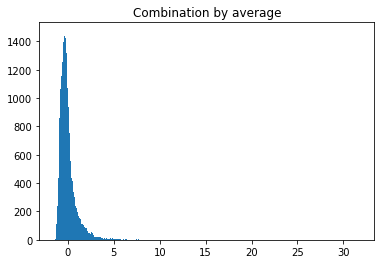

In [ ]:
# Combination by average
y_by_average = average(test_scores_norm)

plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [ ]:
df_test = X_test_scaled.copy()
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<2.7, 0, 1)
df_test[df_test['y_by_average_cluster']==1]['y_by_average_cluster'].count() / df_test['y_by_average_cluster'].count() * 100

2.1806853582554515

In [ ]:
df_test.groupby('y_by_average_cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,y_by_average_score
y_by_average_cluster,,,,,,,,,,,,
0,-0.057992,-0.046980,-0.056505,-0.056121,-0.045525,-0.052783,-0.065003,-0.070494,-0.054218,0.007811,0.007906,-0.10184
1,2.250890,1.740104,2.440669,2.170799,1.677288,2.305079,2.827701,3.029997,2.360563,-0.514879,-0.535799,4.11785


## 5.2 Maximum of Maximum （MOM）

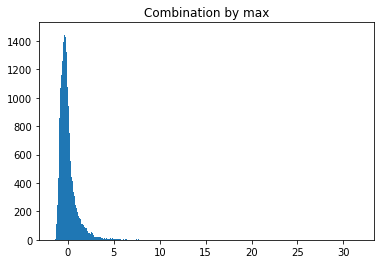

In [ ]:
# Combination by max
y_by_maximization = maximization(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

In [ ]:
df_test = X_test_scaled.copy()
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<2.7, 0, 1)
df_test[df_test['y_by_maximization_cluster']==1]['y_by_maximization_cluster'].count() / df_test['y_by_maximization_cluster'].count() * 100

2.1806853582554515

In [ ]:
df_test.groupby('y_by_maximization_cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,y_by_maximization_score
y_by_maximization_cluster,,,,,,,,,,,,
0,-0.057992,-0.046980,-0.056505,-0.056121,-0.045525,-0.052783,-0.065003,-0.070494,-0.054218,0.007811,0.007906,-0.101726
1,2.250890,1.740104,2.440669,2.170799,1.677288,2.305079,2.827701,3.029997,2.360563,-0.514879,-0.535799,4.117940


## 5.3 The Average of Maximum (AOM)

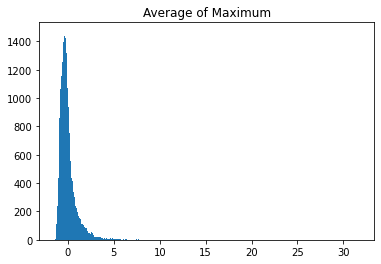

In [ ]:
y_by_aom = aom(test_scores_norm, n_buckets=3)

plt.hist(y_by_aom, bins='auto')
plt.title("Average of Maximum")
plt.show()

In [ ]:
df_test = X_test_scaled.copy()
df_test['y_by_aom_score'] = y_by_aom
df_test['y_by_aom_cluster'] = np.where(df_test['y_by_aom_score']<2.7, 0, 1)
df_test['y_by_aom_cluster'].value_counts()
df_test[df_test['y_by_aom_cluster']==1]['y_by_aom_cluster'].count() / df_test['y_by_aom_cluster'].count() * 100

2.1806853582554515

In [ ]:
df_test.groupby('y_by_aom_cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,y_by_aom_score
y_by_aom_cluster,,,,,,,,,,,,
0,-0.057992,-0.046980,-0.056505,-0.056121,-0.045525,-0.052783,-0.065003,-0.070494,-0.054218,0.007811,0.007906,-0.10184
1,2.250890,1.740104,2.440669,2.170799,1.677288,2.305079,2.827701,3.029997,2.360563,-0.514879,-0.535799,4.11785


## 5.4 The maximum of average (MOA)

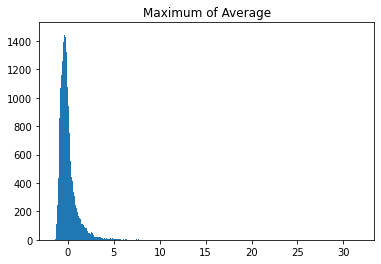

In [ ]:
# Combination by moa
y_by_moa = moa(test_scores_norm, n_buckets=3)

import matplotlib.pyplot as plt
plt.hist(y_by_moa, bins='auto')  # arguments are passed to np.histogram
plt.title("Maximum of Average")
plt.show()

In [ ]:
df_test = X_test_scaled.copy()
df_test['y_by_moa_score'] = y_by_moa
df_test['y_by_moa_cluster'] = np.where(df_test['y_by_moa_score']<2.7, 0, 1)
df_test[df_test['y_by_moa_cluster']==1]['y_by_moa_cluster'].count() / df_test['y_by_moa_cluster'].count() * 100

2.1806853582554515

In [ ]:
df_test.groupby('y_by_moa_cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,y_by_moa_score
y_by_moa_cluster,,,,,,,,,,,,
0,-0.057992,-0.046980,-0.056505,-0.056121,-0.045525,-0.052783,-0.065003,-0.070494,-0.054218,0.007811,0.007906,-0.101726
1,2.250890,1.740104,2.440669,2.170799,1.677288,2.305079,2.827701,3.029997,2.360563,-0.514879,-0.535799,4.117940


# 6.  Isolated Forest

**What is Isolated Forest？**

Isolation Forest is an anomaly detection algorithm that is an alternative to most existing methods, which first identifies isolated anomalies instead of normal data points. Each tree is called an isolation tree or iTree. Since a single tree model tends to lead to overfitting, Isolation Forest randomly selects dimensions and objects from the original dataset and forms *max_samples* subsets, then calculates the average of the anomaly scores of the data points to identify the anomalies.

## 6.1 Build the Model

Standardizing by the whole dataset and randomly split data into training(80%) and testing(20%) dataset.

In [ ]:
# Standardize
from sklearn.preprocessing import StandardScaler
df_standarize = StandardScaler().fit_transform(df_final)
df_standarize = pd.DataFrame(df_standarize)

# Split Data
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df_standarize,test_size=0.2, random_state = 0)

Since the original dataset has 163,065 rows, and the training dataset will have 80% of the rows, which is about 128,000 rows. Therefore, I would like to model with 100,000, 80,000 and 50,000 subsets.

### Model 1: max_samples = 100000

In [ ]:
from pyod.models.iforest import IForest
clf4 = IForest(behaviour="new", max_samples=100000) 
clf4.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=100000, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

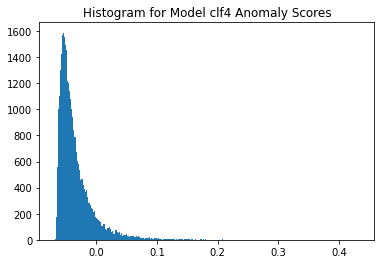

In [ ]:
y_test_scores = clf4.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model clf4 Anomaly Scores")
plt.show()

I assign the observations with less than 0.2 anomaly scores to Cluster 0, and to Cluster 1 for those above 0.2.

In [ ]:
X_test_cluster = X_test.copy()
X_test_cluster['distance'] = y_test_scores
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']<0.2, 0, 1)
X_test_cluster.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,distance
cluster,,,,,,,,,,,,
0,0.005729,0.010740,-0.006715,0.001439,0.002000,-0.009730,-0.005824,-0.002010,-0.004205,0.010758,0.00079,-0.035522
1,-0.007283,-0.009107,-0.000706,-0.006394,-0.007547,0.001389,0.000597,-0.001422,-0.001027,-0.006200,-0.00498,0.218624


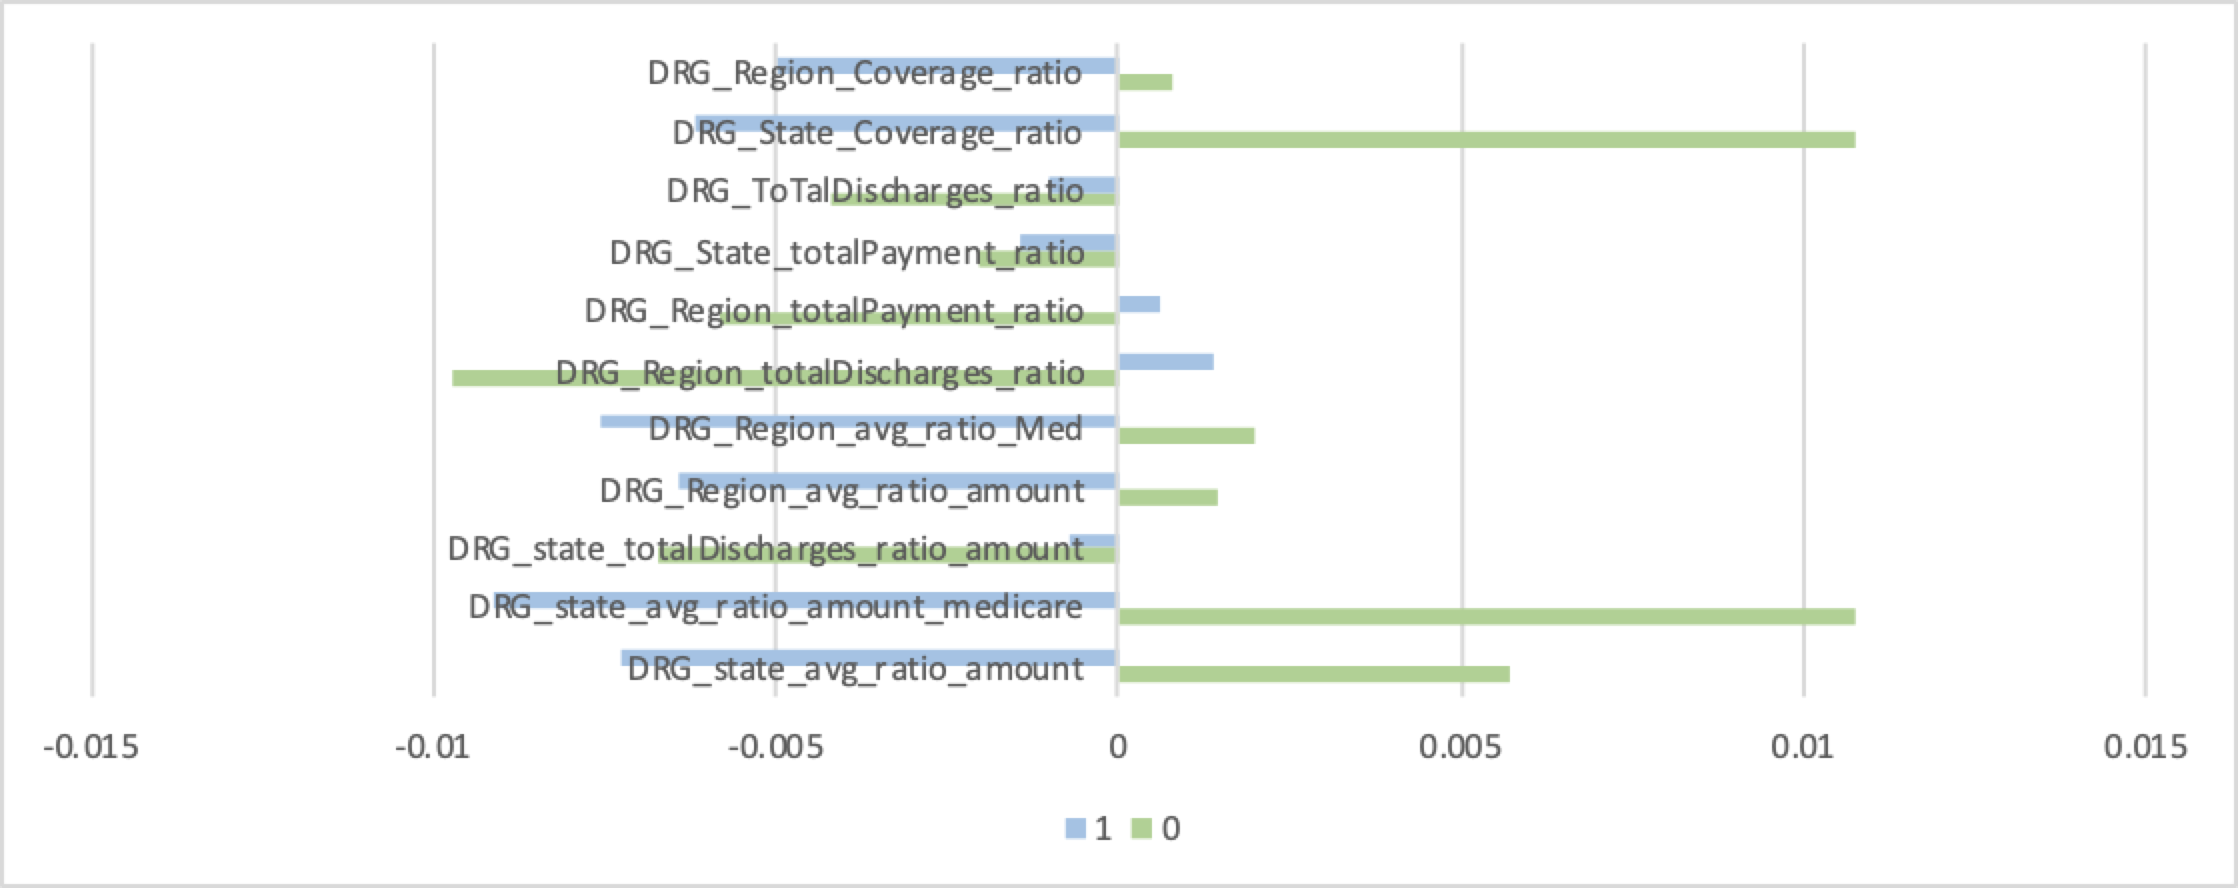

As can be seen by the above results, two clusters were filtered out when the threshold value of scores was set to be greater than 0.2. Among them, the average of scores within cluster 0 is about -0.036, while the sum of scores of each bins within cluster 1 is 0.219, which is much larger than -0.036. Therefore, according to the definition of the iForest algorithm, it is known that cluster 1 are outliers.

Unlike before, the image above shows that there are some features that score higher inside Cluster 0 than Cluster 1.This may indicate that this model is not performing well or some of the created features are not suitable.

### Model 2: max_samples = 80000

In [ ]:
clf5 = IForest(behaviour="new", max_samples=80000) 
clf5.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=80000, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

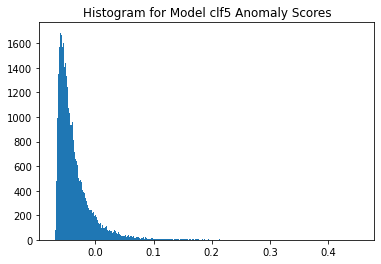

In [ ]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf5.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model clf5 Anomaly Scores")
plt.show()

In [ ]:
X_test_cluster = X_test.copy()
X_test_cluster['distance'] = y_test_scores
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']<0.18, 0, 1)
X_test_cluster['cluster'].value_counts()

X_test_cluster.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,distance
cluster,,,,,,,,,,,,
0,0.005427,0.010642,-0.00707,0.001016,0.001796,-0.010210,-0.006375,-0.002403,-0.004298,0.011285,0.001290,-0.037449
1,-0.007208,-0.009080,-0.00062,-0.006289,-0.007496,0.001505,0.000731,-0.001326,-0.001004,-0.006327,-0.005101,0.219516


Similar to the model 1, two clusters were filtered out when the threshold value of scores was set to be greater than 0.18. Among them, the average of scores within cluster 0 is about -0.037, while the sum of scores of each bins within cluster 1 is 0.219.

### Model 3: max_samples = 50000

In [ ]:
clf6 = IForest(behaviour="new", max_samples=50000) 
clf6.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=50000, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

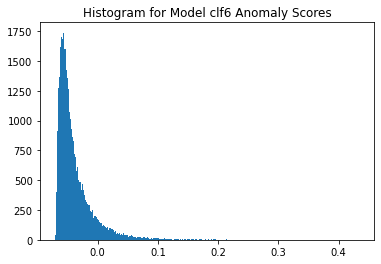

In [ ]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf6.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model clf6 Anomaly Scores")
plt.show()

In [ ]:
X_test_cluster = X_test.copy()
X_test_cluster['distance'] = y_test_scores
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']<0.19, 0, 1)
X_test_cluster.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,distance
cluster,,,,,,,,,,,,
0,0.005785,0.010773,-0.007153,0.001534,0.002042,-0.010257,-0.006259,-0.002372,-0.004451,0.010711,0.000695,-0.038601
1,-0.007296,-0.009114,-0.000599,-0.006417,-0.007557,0.001518,0.000703,-0.001334,-0.000966,-0.006188,-0.004956,0.240690


Similar to the model 1 and model 2, two clusters were filtered out when the threshold value of scores was set to be greater than 0.18. Among them, the average of scores within cluster 0 is about -0.038, while the sum of scores of each bins within cluster 1 is 0.241.

# 7. Aggregating Models

In [ ]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer

# The predictions of the training data can be obtained by clf.decision_scores_.
# It is already generated during the model building process.
train_scores = pd.DataFrame({'clf4': clf4.decision_scores_,
                             'clf5': clf5.decision_scores_,
                             'clf6': clf6.decision_scores_
                            })

# The predictions of the test data need to be predicted using clf.decision_function(X_test)
test_scores  = pd.DataFrame({'clf4': clf4.decision_function(X_test),
                             'clf5': clf5.decision_function(X_test),
                             'clf6': clf6.decision_function(X_test) 
                            })

Standardize the output values for aggregating models.

In [ ]:
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)
train_scores_norm.shape

(130452, 3)

## 7.1 Average

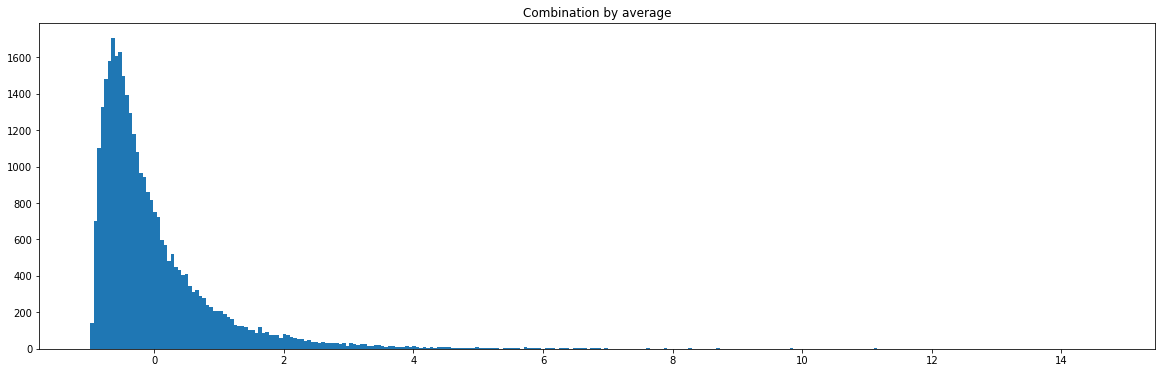

In [ ]:
# Combination by average
y_by_average = average(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.rcParams["figure.figsize"] = (20,8)
plt.show()

In [ ]:
df_test = X_test.copy()
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<6, 0, 1)

df_test.groupby('y_by_average_cluster').mean().round(2)

,0,1,2,3,4,5,6,7,8,9,10,y_by_average_score
y_by_average_cluster,,,,,,,,,,,,
0,-0.02,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.00,-0.00,-0.02
1,4.35,2.95,3.59,3.85,2.57,3.25,4.27,4.99,3.58,-0.91,-1.07,7.71


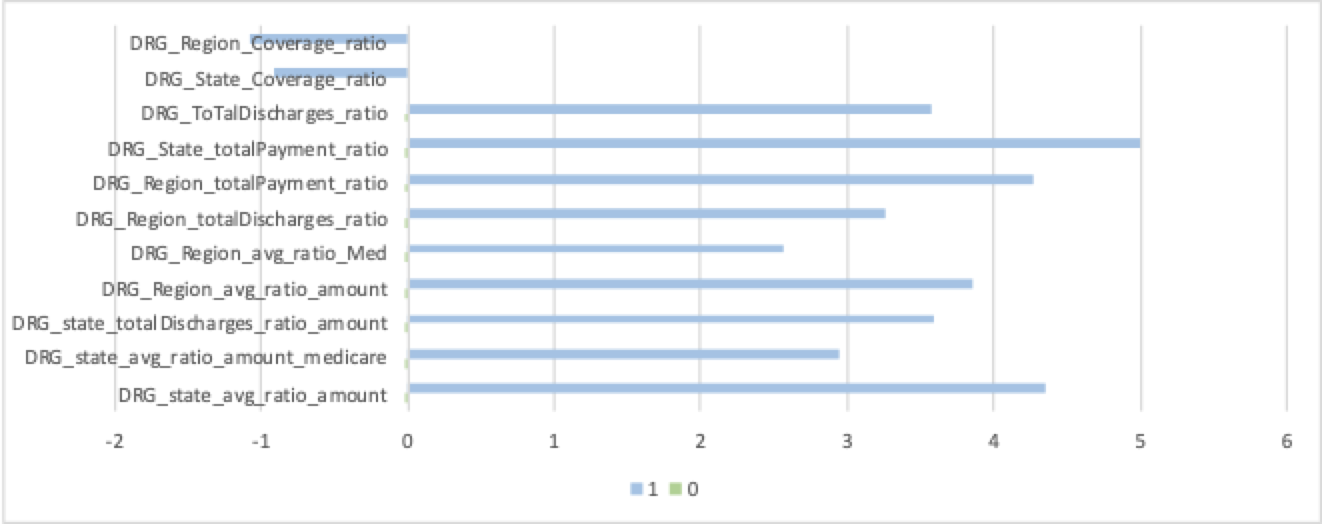

Compared with the results of the single models, aggregating by the average of the scores could better evaluate the performance of the models. 

It is not difficult to find that the average of score of cluster1 under each feature is significantly larger than that of cluster0. It indicates that this is a good modeling and no modification is needed for individual features.

## 7.2 The Maximum of Maximum (MOM)

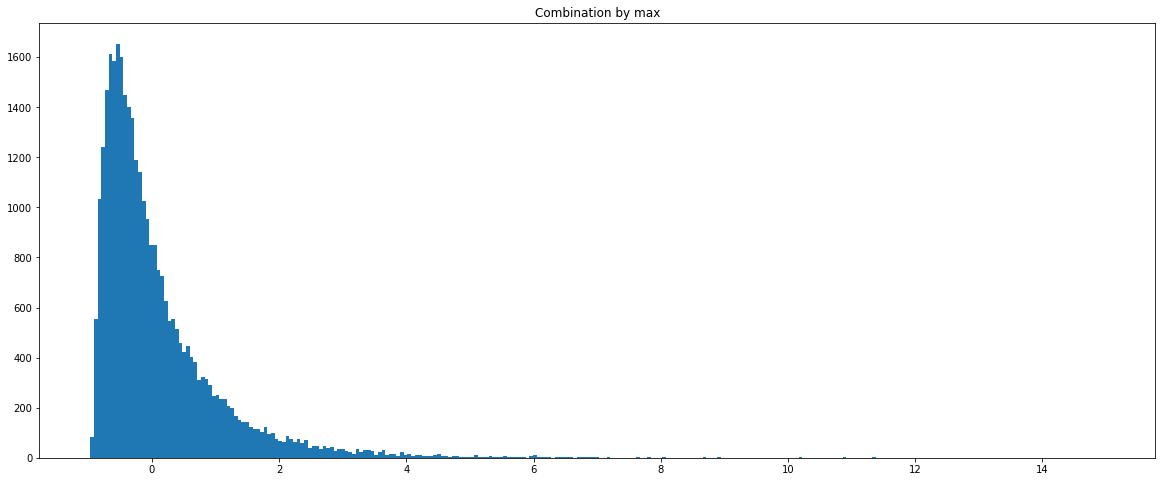

In [ ]:
# Combination by max
y_by_maximization = maximization(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.rcParams["figure.figsize"] = (20,8)
plt.show()

In [ ]:
df_test = X_test.copy()
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<7, 0, 1)
df_test.groupby('y_by_maximization_cluster').mean().round(2)

,0,1,2,3,4,5,6,7,8,9,10,y_by_maximization_score
y_by_maximization_cluster,,,,,,,,,,,,
0,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.00,-0.00,0.08
1,5.73,3.51,3.92,4.96,2.98,3.43,4.68,5.67,3.66,-1.38,-1.51,9.12


The result is similar to the average aggregating model.

The average of score of cluster1 under each feature is significantly larger than that of cluster0. It indicates that this is a good modeling and no modification is needed for individual features.

# 8. Summary

In this session, I learned two new ways to detect outliers. One is to identify noise and calculate outliers by **compressing information** and then reducing it through a neural network approach. The other method is to classify through a **tree model to directly identify outliers.**

In addition, in the Isolated Forest part, I find that the result of single models have a poor performance, which some of the average score of features in cluster 0 are higher than features in cluster 1. But the problem can be sovled by aggregating the models, and it performance well in both Average and the Maximum of Maximum models.